## Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Введение:** <br>
    Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Построим модель для задачи классификации, которая выберет подходящий тариф. Качество модели будем оценивать по значению accuracy. 

## Откроем и изучим файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

In [2]:
df=pd.read_csv('/datasets/users_behavior.csv')
# посмотрим структуру таблицы
print('Структура таблицы')
display(df.head())
print('Количество пользователей тарифа Ultra')
display(df['is_ultra'].value_counts())
print('Соотношение топ-100 пользователей двух тарифов по количеству потраченных минут')
display(df.sort_values(by=['minutes'], ascending=False)[0:100].groupby(['is_ultra'])['minutes'].count())
print('Соотношение топ-100 пользователей двух тарифов по количеству потраченных МБ')
display(df.sort_values(by=['mb_used'], ascending=False)[0:100].groupby(['is_ultra'])['mb_used'].count())

Структура таблицы


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Количество пользователей тарифа Ultra


0    2229
1     985
Name: is_ultra, dtype: int64

Соотношение топ-100 пользователей двух тарифов по количеству потраченных минут


is_ultra
0     9
1    91
Name: minutes, dtype: int64

Соотношение топ-100 пользователей двух тарифов по количеству потраченных МБ


is_ultra
0     8
1    92
Name: mb_used, dtype: int64

Вывод: Данные представляют собой таблицу с информацией о поведении одного пользователя за месяц для тарифа Ультра и Смарт. <br>
    Как мы видим пользователей тарифов Ultra меньше более чем в два раза, но они намного активнее пользуются услугами связи. <br>

## Разобьем данные на выборки

In [3]:
# отделим сначала 40%, так как у нас будет 60/20/20 %
# стратифицируем по 'is_ultra'
df_train, df_40 = train_test_split(df, test_size=0.40, 
                                   random_state=12345, 
                                   stratify=df['is_ultra']) 
df_valid, df_test = train_test_split(df_40, test_size=0.50, 
                                     random_state=12345, 
                                     stratify=df_40['is_ultra']) # поделим пополам 40%

features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

print('Проверка разбиения данных:')
print('df' , df.shape)
print('df_train' , df_train.shape)
print('df_valid' ,df_valid.shape)
print('df_test' ,df_test.shape)



Проверка разбиения данных:
df (3214, 5)
df_train (1928, 5)
df_valid (643, 5)
df_test (643, 5)


## Исследуем модели

1) исследуем модель DecisionTreeClassifier

Найдем при какой depth Accuracy модели DecisionTreeClassifier будет наибольшим.

In [67]:
best_result = 0
model = None
for depth in range(1,15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > best_result:
        best_result = result
        best_depth = depth
        model_DecisionTreeClassifier_best_accuracy = model # сохраним модель с наивысших Accuracy для дальниейшего анализа
        best_predictions = predictions # сохраним predictions для этой модели, чтобы потом также проверить другие метрики
        
      
print("Accuracy лучшей модели DecisionTreeClassifier:", best_result , ', при depth =', best_depth)
print('Посмотрим на другие метрики модели')
print(classification_report(target_valid, best_predictions))

Accuracy лучшей модели DecisionTreeClassifier: 0.80248833592535 , при depth = 8
Посмотрим на другие метрики модели
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       446
           1       0.77      0.51      0.61       197

    accuracy                           0.80       643
   macro avg       0.79      0.72      0.74       643
weighted avg       0.80      0.80      0.79       643



Вывод: модель хорошо себя показывает для определения и охвата пользователей тарифа Смарт, но для тарифа Ультра значения метрик можно попробовать повысить (НИЖЕ). Конечно это также связано с тем, что в выборке(как в генеральной, так и в валидационной) объектов для траифа Ультра более чем в два раза меньше.

In [62]:
# поперебираем другие гиперпараметрами, попробуем улучшить нашу модель
best_result = 0
model = None
for depth in range(1,20):
    for samples_split in range(2,10): # добавил
        for samples_leaf in range(1,10): # добавил
            model = DecisionTreeClassifier(random_state=12345, 
                                           max_depth=depth, 
                                           min_samples_split=samples_split,
                                           min_samples_leaf=samples_leaf)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions)
            if result > best_result:
                best_result = result
                best_depth = depth
                best_samples_split = samples_split # добавил
                best_samples_leaf = samples_leaf # добавил
                model_DecisionTreeClassifier_best_accuracy = model # сохраним модель с наивысших Accuracy для дальниейшего анализа
                best_predictions = predictions # сохраним predictions для этой модели, чтобы потом также проверить другие метрики
        
      
print("Accuracy лучшей модели DecisionTreeClassifier:", best_result , 
      ', при depth =', best_depth,
      ', при samples_split =', best_samples_split,
      ', при samples_leaf =', best_samples_leaf)
print('Посмотрим на другие метрики модели')
print(classification_report(target_valid, best_predictions))

Accuracy лучшей модели DecisionTreeClassifier: 0.8040435458786936 , при depth = 8 , при samples_split = 8 , при samples_leaf = 3
Посмотрим на другие метрики модели
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       446
           1       0.77      0.52      0.62       197

    accuracy                           0.80       643
   macro avg       0.79      0.72      0.74       643
weighted avg       0.80      0.80      0.79       643



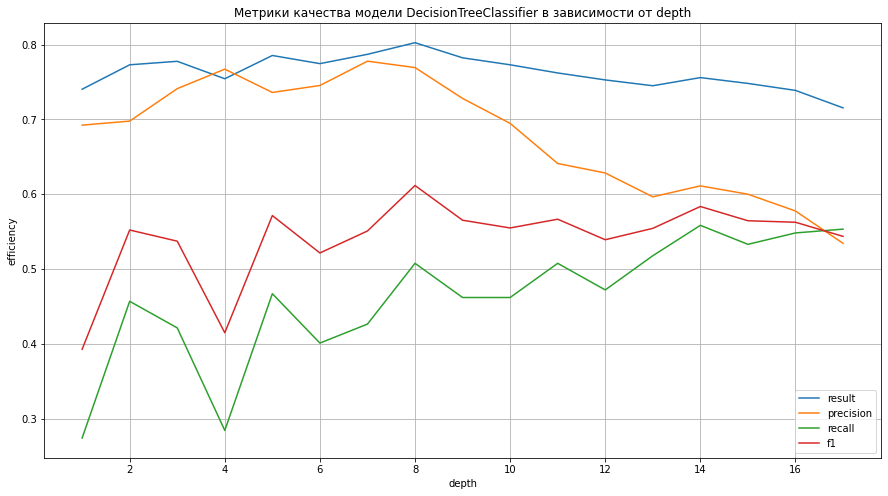

In [61]:
# Построем графики для наглядности. Посмотрим графически как меняются метрики при увеличении глубины обучения модели
best_result = 0
model = None
plt.figure(figsize=(15, 8))

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for depth in range(1,18):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    precision = precision_score(target_valid, predictions)
    recall = recall_score(target_valid, predictions)
    f1 = f1_score(target_valid, predictions)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
      
       
x = [i for i in range(1,18)] 
y = accuracy_list
plt.plot(x,y, label='result')

y = precision_list
plt.plot(x,y, label='precision')

y = recall_list
plt.plot(x,y, label='recall')

y = f1_list
plt.plot(x,y, label='f1')

plt.legend()    
plt.title('Метрики качества модели DecisionTreeClassifier в зависимости от depth')    
plt.xlabel('depth') 
plt.ylabel('efficiency') 
plt.grid() 


[Text(393.88235294117646, 489.24, 'minutes <= 748.465\ngini = 0.425\nsamples = 643\nvalue = [446, 197]'),
 Text(196.94117647058823, 380.52000000000004, 'mb_used <= 27207.59\ngini = 0.374\nsamples = 578\nvalue = [434, 144]'),
 Text(98.47058823529412, 271.8, 'minutes <= 4.385\ngini = 0.33\nsamples = 538\nvalue = [426, 112]'),
 Text(49.23529411764706, 163.08000000000004, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(147.70588235294116, 163.08000000000004, 'messages <= 116.0\ngini = 0.319\nsamples = 532\nvalue = [426, 106]'),
 Text(98.47058823529412, 54.360000000000014, '\n  (...)  \n'),
 Text(196.94117647058823, 54.360000000000014, '\n  (...)  \n'),
 Text(295.4117647058823, 271.8, 'minutes <= 283.55\ngini = 0.32\nsamples = 40\nvalue = [8, 32]'),
 Text(246.1764705882353, 163.08000000000004, 'gini = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(344.6470588235294, 163.08000000000004, 'messages <= 6.5\ngini = 0.426\nsamples = 26\nvalue = [8, 18]'),
 Text(295.4117647058823, 54.36000000000001

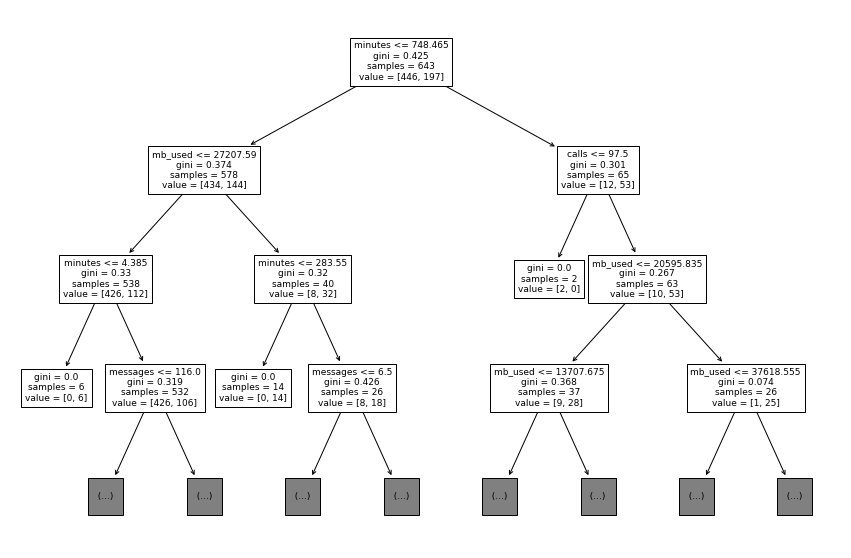

In [30]:
# построим tree_plot, чтобы посмотреть как работает модель
clf = tree.DecisionTreeClassifier(random_state=12345, max_depth=8)
clf = clf.fit(features_valid, target_valid)
plt.figure(figsize=(15,10))
tree.plot_tree(clf, max_depth=3, fontsize=9, feature_names=features_valid.columns)

Вывод: принцип выбора прослеживается, видим глубину 8

2) исследуем модель RandomForestClassifier

In [15]:
features_train

,calls,minutes,messages,mb_used
2294,76.0,484.49,11.0,22454.35
1759,51.0,328.88,24.0,20511.93
529,105.0,705.05,18.0,22130.74
1599,19.0,135.52,48.0,13152.50
1868,28.0,159.55,0.0,14780.00
...,...,...,...,...
1967,102.0,654.92,40.0,18362.08
920,95.0,732.20,44.0,28042.76
2456,26.0,169.77,16.0,11684.21
756,51.0,401.45,91.0,19021.56


In [37]:
%%time
best_accuracy_result = 0
model = None
for est in range(22,40,3):
    for depth in range(1,32,10): # добавил
        for samples_split in range(8,21, 2): # добавил
            for samples_leaf in range(1,5): # добавил
                model = RandomForestClassifier(random_state=12345, n_estimators=est, 
                                               max_depth=depth, 
                                               min_samples_split=samples_split,
                                               min_samples_leaf=samples_leaf) 
                model.fit(features_train, target_train)
                predictions = model.predict(features_valid)
                accuracy_result = accuracy_score(target_valid, predictions)
                if accuracy_result > best_accuracy_result: 
                    best_accuracy_result = accuracy_result 
                    best_accuracy_est = est
                    best_depth = depth
                    best_samples_split = samples_split # добавил
                    best_samples_leaf = samples_leaf # добавил
                    model_RandomForestClassifier_best_accuracy = model # сохраним модель с best accuracy
               
        
print("Наилучшая Accuracy модели RandomForestClassifier:", best_accuracy_result, 
      ', при depth =', best_depth, 
      ', при n_estimators =', best_accuracy_est,
      ', при samples_split =', best_samples_split,
      ', при samples_leaf =', best_samples_leaf) 
     

Наилучшая Accuracy модели RandomForestClassifier: 0.8195956454121306 , при depth = 11 , при n_estimators = 22 , при samples_split = 12 , при samples_leaf = 1
CPU times: user 59.2 s, sys: 391 ms, total: 59.6 s
Wall time: 59.7 s


In [10]:
%%time
# посмотрим, что нам выдаст GridSearch
# так как GridSearch сам выделяет валидационную выборку, объединим наши выборки train и valid
grid_features_train = pd.concat([features_train, features_valid])
grid_target_train = pd.concat([target_train, target_valid])


clf = RandomForestClassifier()
parametrs = { 'n_estimators': range (1, 31, 5),
              'max_depth': range (10,30, 2),
              'min_samples_leaf': range (1,3),
              'min_samples_split': range (5,15) }
grid = GridSearchCV(clf, parametrs)

grid.fit(grid_features_train, grid_target_train)

grid.best_params_
grid.best_score_

CPU times: user 5min 9s, sys: 1.62 s, total: 5min 10s
Wall time: 5min 11s


0.8090196819160591

In [11]:
grid.best_params_

{'max_depth': 16,
 'min_samples_leaf': 2,
 'min_samples_split': 14,
 'n_estimators': 26}

Вывод: Выбрали модель RandomForestClassifier с наивысшим Accuracy 0,86 и обозначили ее как model_RandomForestClassifier_best_accuracy. Grid выдал нам модель с меньшей Accuracy

3) исследуем модель LogisicRegression

In [59]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
recall = recall_score(target_valid, predictions)
print("Accuracy модели LogisticRegresion:", accuracy)
print("Recall модели LogisticRegresion:", recall)
model_LogisticRegression = model
#dump(model, 'model_9_1.joblib')

Accuracy модели LogisticRegresion: 0.7387247278382582
Recall модели LogisticRegresion: 0.19289340101522842


Вывод: <br>
Самое высокое Accuracy, у дерева решений: accuracy = 0,80 при глубине 8 . <br>
На втором месте — случайный лес: accuracy = 0,799 при 21 деревьях. <br>
Самое низкое качество предсказания у логистической регрессии: 0,74. Но зато самая высокая скорость работы у логистической регрессии: у неё меньше всего параметров.<br>
<br>
Если будем искать оптимальное решение по recall для тарифа Ультра, то получим: <br>
1) Recall = 0.57 для модели RandomForestClassifier, где Accuracy: 0.7947122861 , при n_estimators = 27 <br>
2) Recall = 0.56 для модели DecisionTreeClassifier, где Accuracy: 0.7558320373250389 , при depth = 14 <br>
3) Recall = 0.19 для модели LogisticRegresion, где Accuracy: 0.0.7387247278382582<br>
<br>
<br>
Как видим модель LogisticRegression значительно отстает от двух других моделей по качеству

## Проверим модель на тестовой выборке

In [31]:
# перед проверкой на тестовой выборке переобучим нашу модель RFC на train+valid выборке
model = RandomForestClassifier(random_state=12345, n_estimators=22, 
                                               max_depth=11, 
                                               min_samples_split=12,
                                               min_samples_leaf=1)
model.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))
model_RandomForestClassifier_best_accuracy = model

In [32]:
predictions = model_RandomForestClassifier_best_accuracy.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print("Accuracy модели RandomForestClassifier c best-accuracy на тестовой выборке:", accuracy)


Accuracy модели RandomForestClassifier c best-accuracy на тестовой выборке: 0.8304821150855366


Вывод: 

Точность получается 83%, цель достигнута.


## Проверим модель на адекватность

In [14]:
model = DummyClassifier(strategy="most_frequent")
model.fit(features_train,target_train)
model.predict(features_test)
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print(accuracy)

print(classification_report(target_test, predictions))

0.6936236391912908
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       446
           1       0.00      0.00      0.00       197

    accuracy                           0.69       643
   macro avg       0.35      0.50      0.41       643
weighted avg       0.48      0.69      0.57       643



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Вывод: модель адекватна при точности более 69%. Обученная нами модель выдает 83%, что значительно выше.